# UA Classification via Classification and Cost Analysis

In [1]:
#pip install --upgrade notebook

In [2]:
#pip install xgboost --quiet

In [3]:
#pip install lightgbm --quiet

In [4]:
#pip install catboost --quiet

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import re
import time
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import pointbiserialr
from collections import Counter

from unidecode import unidecode
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier 
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

## 0. Setting the Notebook Parameters

In [6]:
# Set notebook parameters
file_path = "BBDD_V6_SINCO_without_NAs_SoftImputer.csv"
KPI = 'BMA_pol_auto' # KPI to be considered to classify customers as 0 (to be selected) or 1 (to be excluded)
threshold = 0 # if KPI > threshold then customer belongs to class 0; otherwise, customer belongs to class 1
max_n_features = 15 # maximum number of relevant features per model to use
features_choice = 'default' # You can use 'union', 'intersection', 'top_corr_feat' 'top_mi_feat', or 'default'
score_name = 'roc_auc' # select the score to optimize ('roc_auc', 'f1', 'recall', etc.)
use_scaling = True # choose True if you want to scale X data
remove_missing_sinco_rows = True # choose True to remove rows without sinco info
use_sinco_columns = True # choose True to include sinco variables in the model
verbose = False # choose True if you want more output details
if verbose: pd.set_option('display.max_rows', None)
replace_outliers = False # choose True to replace outliers by their closest bound (winsorizing)
feature_selection = True # choose True if you want to add just a few relevant features to X
fast_execution = True # choose False if you want to include slower methods
consider_consensus = True # choose False if you want to keep the best model in the pool with CV
# Print notebook parameters
print("Working file has been set to", file_path)
print("KPI has been set to", KPI)
print("Parameter 'max_n_features' has been set to", max_n_features)
print("Parameter 'features_choice' has been set to", features_choice)
if features_choice == 'default': print(" ('default' is the union of sets 'union' and 'top_mi_feat')")
print("Parameter 'score_name' has been set to", score_name)
print("Parameter 'use_scaling' has been set to", use_scaling)
print("Parameter 'remove_missing_sinco_rows' has been set to", remove_missing_sinco_rows)
print("Parameter 'use_sinco_columns' has been set to", use_sinco_columns)
print("Parameter 'verbose' has been set to", verbose)
print("Parameter 'replace_outliers' has been set to", replace_outliers)
print("Parameter 'feature_selection' has been set to", feature_selection)
print("Parameter 'fast_execution' has been set to", fast_execution)
print("Parameter 'consider_consensus' has been set to", consider_consensus)

Working file has been set to BBDD_V6_SINCO_without_NAs_SoftImputer.csv
KPI has been set to BMA_pol_auto
Parameter 'max_n_features' has been set to 15
Parameter 'features_choice' has been set to default
 ('default' is the union of sets 'union' and 'top_mi_feat')
Parameter 'score_name' has been set to roc_auc
Parameter 'use_scaling' has been set to True
Parameter 'remove_missing_sinco_rows' has been set to True
Parameter 'use_sinco_columns' has been set to True
Parameter 'verbose' has been set to False
Parameter 'replace_outliers' has been set to False
Parameter 'feature_selection' has been set to True
Parameter 'fast_execution' has been set to True
Parameter 'consider_consensus' has been set to True


## 1. Data Preprocessing

In [7]:
# Read the data file
df = pd.read_csv(file_path)
# Remove additional columns as indicated by Raquel
col_to_remove = ['PrimaTotalPoliza', 'ComisionTotalPoliza', 'SiniestralidadTotalPoliza', 'ExposicionTotalPoliza']
df = df.drop(columns=col_to_remove)
print("The following columns have been removed:\n", col_to_remove)
print("\nDataset shape (rows, columns):", df.shape)
# Use unicode characters for column names and remove non-alphanumeric characters
df.columns = [unidecode(column) for column in df.columns]
df.columns = [re.sub(r'\W+', '_', column) for column in df.columns]
print("Non-unicode characters in columns' names have been removed to avoid issues with models.")

The following columns have been removed:
 ['PrimaTotalPoliza', 'ComisionTotalPoliza', 'SiniestralidadTotalPoliza', 'ExposicionTotalPoliza']

Dataset shape (rows, columns): (116650, 192)
Non-unicode characters in columns' names have been removed to avoid issues with models.


In [8]:
# Define function to shorten column name
def shorten_column_name(column_name, max_length=30, prefix_length=15, suffix_length=15):
    if len(column_name) <= max_length: return column_name
    else: return column_name[:prefix_length] + '_' + column_name[-suffix_length:]
    
# Shorten column names in DataFrame
df.columns = [shorten_column_name(column) for column in df.columns]
print("Long names in columns have been shortened to avoid issues with models.")

Long names in columns have been shortened to avoid issues with models.


In [9]:
# Display the first rows of the dataframe
df.head()

,id17,id18,id21,id55,id58_1,id58_2,id58_3,id59,id60,id61,...,NotaLUA_B,NotaLUA_C,NotaLUA_D,NotaLUA_E,NotaLUA_F,NotaLUA_G,SINCO,Cliente_Diverso,BMA_pol,BMA_pol_auto
0,31.0,403.0,3720.0,-50.0,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,44.571968,44.571968
1,160.0,1.0,29180.0,-50.0,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,109.816034,109.816034
2,600.0,110.0,3009.0,-50.0,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,107.068853,107.068853
3,461.0,51.0,46717.0,-50.0,0.0,1.0,0.0,2961.46,552.33,141.83,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,236.286600,236.286600
4,31.0,403.0,3720.0,-50.0,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,216.643160,216.643160


In [10]:
print("Feature names:\n")
if verbose: print(df.columns.tolist())
else: print(df.columns)

Feature names:

Index(['id17', 'id18', 'id21', 'id55', 'id58_1', 'id58_2', 'id58_3', 'id59',
       'id60', 'id61',
       ...
       'NotaLUA_B', 'NotaLUA_C', 'NotaLUA_D', 'NotaLUA_E', 'NotaLUA_F',
       'NotaLUA_G', 'SINCO', 'Cliente_Diverso', 'BMA_pol', 'BMA_pol_auto'],
      dtype='object', length=192)


In [11]:
# Display the data type of each column
print(df.dtypes)

id17               float64
id18               float64
id21               float64
id55               float64
id58_1             float64
                    ...   
NotaLUA_G          float64
SINCO              float64
Cliente_Diverso    float64
BMA_pol            float64
BMA_pol_auto       float64
Length: 192, dtype: object


In [12]:
# If required, remove rows without SINCO information
print("Dataframe shape before rows removal (if any) operation:", df.shape)
if remove_missing_sinco_rows:
    df = df[df['SINCO'] != 0]
    print("Rows without SINCO data have been removed.")
else: print("The dataset contains rows without SINCO data.")
print("Dataframe shape after rows removal (if any) operation:", df.shape)

Dataframe shape before rows removal (if any) operation: (116650, 192)
Rows without SINCO data have been removed.
Dataframe shape after rows removal (if any) operation: (51546, 192)


In [13]:
# Identify SINCO columns in the dataset
sinco_columns = [col for col in df.columns if 'SINCO' in col]
sinco_columns += ['id55'] # is also SINCO as indicated by Raquel
print("The following SINCO columns have been identified:\n\n", sinco_columns)

The following SINCO columns have been identified:

 ['SINCOTotalVehiculos', 'TiempoSINCO', 'PerteneceSINCO', 'TotalMatriculasSINCO', 'TiempoMedioSINCO', 'TiempoSeguroSINCO', 'TiempoSINCO_Anos', 'FrecuenciaSiniestroSINCO', 'NV_AutomovilSINCO', 'NV_MotocicletaSINCO', 'NV_OtrosSINCO', 'SINCOMatriculaIncluida', 'NumeroDanyosMaterialesSINCO', 'ProcesoDanyosMaterialesSINCO', 'NumeroDanyosPersonalesSINCO', 'ProcesoDanyosPersonalesSINCO', 'TipoConsultaSINCO_Tomador', 'SINCO', 'id55']


In [14]:
# If required, delete SINCO columns
if use_sinco_columns == False:
    df = df.drop(columns=sinco_columns)
    print("SINCO columns have been removed from dataframe.")
else: print("SINCO columns are still included in the dataframe.")

SINCO columns are still included in the dataframe.


In [15]:
# Calculate missing data for each column
def calc_missing_data(data):
    print(data.shape)
    missing_data = data.isna().sum()
    missing_data = missing_data.sort_values(ascending=False)
    print("Columns with more missing data:")
    print(missing_data.head())
    total_missing = missing_data.sum()
    print("\nTotal number of missing data:", total_missing)
    return total_missing

total_missing = calc_missing_data(df)

(51546, 192)
Columns with more missing data:
id17                 0
id18                 0
TiempoMedioSINCO     0
TiempoSeguroSINCO    0
TiempoSINCO_Anos     0
dtype: int64

Total number of missing data: 0


In [16]:
# Impute missing data using a fast method
if total_missing > 0:
    df.fillna(df.median(), inplace=True)
    print("Missing data has been imputed using a fast method.\n")
    total_missing = calc_missing_data(df)
else: print ("There was not missing data in the dataframe.")

There was not missing data in the dataframe.


## 2. Defining Target

In [17]:
# Describe KPI variable
print("Summary of statistics for KPI variable", KPI, "in X.")
df[KPI].describe()

Summary of statistics for KPI variable BMA_pol_auto in X.


count     51546.000000
mean         45.242747
std        2479.687340
min     -185990.403750
25%          75.253375
50%         181.123669
75%         272.209048
max       28207.913409
Name: BMA_pol_auto, dtype: float64

Boxplot of KPI in dataset X:



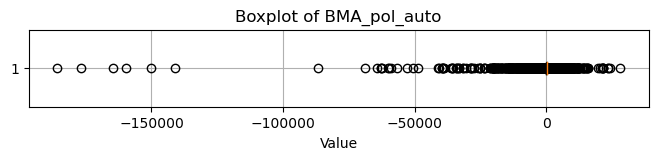

In [18]:
# Boxplot of the KPI
def plot_boxplot(X, var):
    plt.figure(figsize=(8, 1))
    plt.boxplot(X[var], vert=False)
    plt.title('Boxplot of ' + var)
    plt.xlabel('Value')
    plt.grid(True)
    plt.show()

print("Boxplot of KPI in dataset X:\n")
plot_boxplot(df, KPI)

In [19]:
# Create the class_true variable based on each client's KPI and the user-defined threshold
df['true_class'] = np.where(df[KPI] > threshold, 0, 1)
print(f"True class of each customer: 0 (selected) if KPI>{threshold}, or 1 (excluded) otherwise.")
if threshold != 0:
    print("\nTake into account the user-defined threshold when interpreting the consensus matrices.")

True class of each customer: 0 (selected) if KPI>0, or 1 (excluded) otherwise.


In [20]:
# Select the target variable
target = 'true_class'
col_to_drop = [target, 'BMA_pol', 'BMA_pol_auto'] # columns to drop from set of features (X)
print("The target variable is:", target, "with type", df[target].dtype)
print("\nThe following columns will be dropped from set of predictive features (X):\n", col_to_drop)

The target variable is: true_class with type int64

The following columns will be dropped from set of predictive features (X):
 ['true_class', 'BMA_pol', 'BMA_pol_auto']


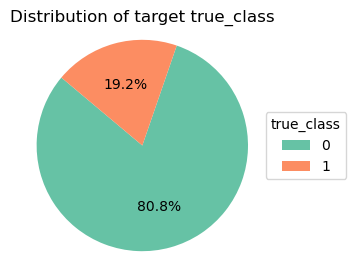

In [21]:
# Count the occurrences of each unique value in the binary target variable
target_counts = df[target].value_counts()
# Plot a pie chart
colors = ['#66c2a5', '#fc8d62']  # soft pastel colors
plt.figure(figsize=(3, 3)) 
plt.pie(target_counts, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title(f"Distribution of target {target}")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(labels=target_counts.index, title=target, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [22]:
# Compute the average and total benefit before applyting any classification model to filter customers
print(f"Total customers in dataset: {df.shape[0]:,.0f} customers in X")
max_benefit = df[df[KPI] > 0][KPI].sum()
real_benefit = df[KPI].sum()
p_r_benefit = int(round(100 * real_benefit / max_benefit, 0))
avg_r_benefit = df[KPI].mean()
print(f"Based on KPI, maximum possible benefit in X: {max_benefit:,.0f} euros")
print(f"Based on KPI, real benefit before applying any model: {real_benefit:,.0f} euros ({p_r_benefit}% of max)")
print(f"Based on KPI, avg. benefit before applying any model: {avg_r_benefit:,.2f} euros per cust. in dataset")

Total customers in dataset: 51,546 customers in X
Based on KPI, maximum possible benefit in X: 14,247,061 euros
Based on KPI, real benefit before applying any model: 2,332,083 euros (16% of max)
Based on KPI, avg. benefit before applying any model: 45.24 euros per cust. in dataset


## 3. Outliers Management

In [23]:
# Make a copy of the KPI column before possible replacement of outliers
KPI_copy = KPI + '_original'
df[KPI_copy] = df[KPI].copy()
print("A copy of the original KPI column has been made before possible replacement of outliers.")
print("\nThe following columns will be dropped from set of features (X):\n", col_to_drop)

A copy of the original KPI column has been made before possible replacement of outliers.

The following columns will be dropped from set of features (X):
 ['true_class', 'BMA_pol', 'BMA_pol_auto']


In [24]:
# Define a function to replace outliers with the closest non-outlier value (winsoring technique)
def modify_outliers(var):
    Q1 = var.quantile(0.25)
    Q3 = var.quantile(0.75)
    IQR = Q3 - Q1
    lb = Q1 - 1.5 * IQR
    ub = Q3 + 1.5 * IQR
    var.loc[var < lb] = lb
    var.loc[var > ub] = ub
    return var

# If requested, iterate over float columns and replace outliers 
if replace_outliers:
    for column in df.select_dtypes(include=['float64', 'float32']).columns:
        if column != KPI_copy and column != target: # keep outliers in these columns
            df[column] = modify_outliers(df[column])
    print("Outliers have been replaced by their closest bound.")
else: print("No outliers have been replaced.")

No outliers have been replaced.


In [25]:
# Additional boxplots of variables
if replace_outliers: 
    plot_boxplot(KPI_copy)
    plot_boxplot(KPI)
    plot_boxplot(feature)
else: print("No new plots since outliers have NOT been replaced.")

No new plots since outliers have NOT been replaced.


## 4. Biserial Correlation and Mutual Information with target

In [26]:
# If required, add columns to drop from features set X
col_to_drop += []
print("The following columns will be dropped from set of features (X):\n", col_to_drop)

The following columns will be dropped from set of features (X):
 ['true_class', 'BMA_pol', 'BMA_pol_auto']


In [27]:
# Compute biserial correlations (in absolute value) between the target and numerical features
numerical_columns = df.select_dtypes(include=['number']).columns
correlations = {}
for col in numerical_columns:
    correlation, _ = pointbiserialr(df[col], df[target])
    correlations[col] = abs(correlation)

sorted_correlations = pd.Series(correlations).sort_values(ascending=False)
# Drop unwanted columns if they exist
sorted_correlations.drop(col_to_drop, inplace=True)
sorted_correlations.drop(KPI_copy, inplace=True)
# Filter correlations greater than a given value in absolute value
min_corr_val = 0.1
sorted_correlations = sorted_correlations[sorted_correlations > min_corr_val]
print("Top", len(sorted_correlations), "significant biserial correlations (in abs) with target:")
print(sorted_correlations)
# Keep a list of features with high correlations
top_corr_feat = sorted_correlations.index.tolist()
print("\nTop", len(top_corr_feat), "biserial correlated features:\n", top_corr_feat)

Top 2 significant biserial correlations (in abs) with target:
Cliente_Diverso    0.151522
id55               0.140211
dtype: float64

Top 2 biserial correlated features:
 ['Cliente_Diverso', 'id55']


In [28]:
# Compute mutual information (non-linear relationship) between the target and numerical features
top_mi_feat = set() # initialize empty set in case fast_execution is activated
print("Top mutual information has been initilizad as an empty set.")
if fast_execution == False:
    mi = mutual_info_classif(df[numerical_columns], df[target])
    # Create a dictionary of mutual information values
    mi_dict = {col: mi_val for col, mi_val in zip(numerical_columns, mi)}
    # Convert to a pandas Series for sorting
    sorted_mi = pd.Series(mi_dict).sort_values(ascending=False)
    # Drop unwanted columns if they exist
    sorted_mi.drop(col_to_drop, inplace=True)
    sorted_mi.drop(KPI_copy, inplace=True)
    # Filter mutual information values greater than a given value
    min_mi_val = 0.01
    sorted_mi = sorted_mi[sorted_mi > min_mi_val]
    print("\nTop", len(sorted_mi), "significant mutual information values with target:")
    print(sorted_mi)
    # Keep a list of features with high mutual information values
    top_mi_feat = sorted_mi.index.tolist()
    print("\nTop", len(top_mi_feat), "mutual information features:\n", top_mi_feat)
else: print("\nIn fast execution mode, mutual information (non-linear relationships) is not computed.")

Top mutual information has been initilizad as an empty set.

In fast execution mode, mutual information (non-linear relationships) is not computed.


## 5. Features Selection and Train-Test Split

### 5a. Selection of Target y and Preliminary Features X

In [29]:
# Select the target y and the preliminary predictive features X
y = df[target]
X = df[numerical_columns].drop(columns=col_to_drop)
print("Target y and preliminary predictors X have been defined.")
print("\nThe following columns have been dropped from set of features (X):\n", col_to_drop)
if KPI_copy in X.columns: print("\nVariable", KPI_copy, "is still in X.")
else: print("\nVariable", KPI_copy, "is NOT in X.")

Target y and preliminary predictors X have been defined.

The following columns have been dropped from set of features (X):
 ['true_class', 'BMA_pol', 'BMA_pol_auto']

Variable BMA_pol_auto_original is still in X.


In [30]:
# Split y and preliminary X into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Target y and preliminary X have been split into train and test sets.")
if KPI_copy in X_train.columns and KPI_copy in X_test.columns: 
    print("\nVariable", KPI_copy, "is in X_train and X_test.")
else: print("\nVariable", KPI_copy, "is NOT in X_train and X_test.")    

Target y and preliminary X have been split into train and test sets.

Variable BMA_pol_auto_original is in X_train and X_test.


### 5b. Feature Importance

In [31]:
def get_relevant_features(model, X_train_red, y_train):
    print("\n" + type(model).__name__ + "...")
    start_time = time.time()
    model.fit(X_train_red, y_train)
    # Get feature importances and sort features by importance
    feature_importances = model.feature_importances_
    feature_importance_list = list(zip(X_train_red.columns, feature_importances))
    feature_importance_list = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)
    # Print the sorted list of features and their importances
    relevant_features = []
    feature_importance_list = [item for item in feature_importance_list if item[1] > 0.01]
    for feature, importance in feature_importance_list[:max_n_features]:
        relevant_features.append(feature)
        print("   " + feature + " (" + str(round(importance, 2)) + ")")
    print("Elapsed:", int(round(time.time() - start_time,0)), "sec.")
    return relevant_features

X_train_red = X_train.drop(columns=[KPI_copy]) # temporarily remove KPI_copy from relevant features
print("Variable", KPI_copy, "has been temporarily removed from X_train.")
print("\nDisplaying top relevant features (importance) for each model:")
relevant_features = {}
models = [XGBClassifier(), LGBMClassifier(verbosity=-1)]
if fast_execution == False: models += [ExtraTreesClassifier(), RandomForestClassifier(), 
                                       CatBoostClassifier(verbose=False)]

for model in models: 
    relevant_features[model.__class__.__name__] = set(get_relevant_features(model, X_train_red, y_train))

Variable BMA_pol_auto_original has been temporarily removed from X_train.

Displaying top relevant features (importance) for each model:

XGBClassifier...
   id55 (0.04)
   Cliente_Diverso (0.02)
   FrecuenciaSiniestroSINCO (0.02)
   AnyoPoliza (0.02)
   NumeroDanyosMaterialesSINCO (0.01)
   PerteneceSINCO (0.01)
Elapsed: 3 sec.

LGBMClassifier...
   AnyoPoliza (161)
   id55 (130)
   ValorVehiculoMercado (94)
   TiempoMedioSINCO (87)
   TiempoSINCO (61)
   PerteneceSINCO (56)
   FrecuenciaSiniestroSINCO (56)
   Antiguedad_Carnet (55)
   Edad (54)
   id70 (50)
   TiempoSeguroSINCO (46)
   SINCOTotalVehiculos (45)
   ScoreCanal (42)
   AntiguedadVehiculo (42)
   id18 (33)
Elapsed: 2 sec.


In [32]:
# Get the union of relevant features from all models
relevant_features_union = set.union(*relevant_features.values())
relevant_features_union = list(relevant_features_union)
print("The union of relevant features contains", len(relevant_features_union), "features:")
print(relevant_features_union)
# Get the intersection of relevant features from all models
relevant_features_intersection = set.intersection(*relevant_features.values())
relevant_features_intersection = list(relevant_features_intersection)
print("\nThe intersection of relevant features contains", len(relevant_features_intersection), "features.")
print(relevant_features_intersection)

The union of relevant features contains 17 features:
['Cliente_Diverso', 'Edad', 'TiempoMedioSINCO', 'FrecuenciaSiniestroSINCO', 'TiempoSINCO', 'id55', 'ValorVehiculoMercado', 'AntiguedadVehiculo', 'PerteneceSINCO', 'ScoreCanal', 'id18', 'SINCOTotalVehiculos', 'NumeroDanyosMaterialesSINCO', 'AnyoPoliza', 'TiempoSeguroSINCO', 'id70', 'Antiguedad_Carnet']

The intersection of relevant features contains 4 features.
['FrecuenciaSiniestroSINCO', 'AnyoPoliza', 'PerteneceSINCO', 'id55']


### 5c. Using Feature Importance re-define X and Train-Test Split

In [33]:
# Based on the features importance and availability, define the relevant features to be included in X 
if features_choice == 'union': relevant_features = relevant_features_union
elif features_choice == 'intersection': relevant_features = relevant_features_intersection
elif features_choice == 'top_mi_feat': relevant_features = top_mi_feat
elif features_choice == 'top_corr_feat': relevant_features = top_corr_feat
else: relevant_features = list(set(relevant_features_union).union(top_mi_feat))
print("Features choice was set to", features_choice, "with", len(relevant_features), "features")
print("\nSelected", len(relevant_features), "relevant features are: \n", relevant_features)

Features choice was set to default with 17 features

Selected 17 relevant features are: 
 ['Cliente_Diverso', 'Edad', 'TiempoMedioSINCO', 'FrecuenciaSiniestroSINCO', 'TiempoSINCO', 'id55', 'ValorVehiculoMercado', 'AntiguedadVehiculo', 'PerteneceSINCO', 'ScoreCanal', 'id18', 'SINCOTotalVehiculos', 'NumeroDanyosMaterialesSINCO', 'AnyoPoliza', 'TiempoSeguroSINCO', 'id70', 'Antiguedad_Carnet']


In [34]:
# Re-define X and train-test split
if feature_selection: 
    X = df[relevant_features]
    print("X has been re-set to consider the following relevant features: \n", relevant_features)
    X[KPI_copy] = df[KPI_copy]
    print("\nVariable", KPI_copy, "has been temporarily included in X as well.")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    print("\nNew X and y have been split into train and test sets.")
else: print("X and train-test sets have not been modified. Careful: X includes", KPI_copy)

X has been re-set to consider the following relevant features: 
 ['Cliente_Diverso', 'Edad', 'TiempoMedioSINCO', 'FrecuenciaSiniestroSINCO', 'TiempoSINCO', 'id55', 'ValorVehiculoMercado', 'AntiguedadVehiculo', 'PerteneceSINCO', 'ScoreCanal', 'id18', 'SINCOTotalVehiculos', 'NumeroDanyosMaterialesSINCO', 'AnyoPoliza', 'TiempoSeguroSINCO', 'id70', 'Antiguedad_Carnet']

Variable BMA_pol_auto_original has been temporarily included in X as well.

New X and y have been split into train and test sets.


In [35]:
# Describe KPI_copy for the X_train rows
print("Summary of statistics for KPI variable", KPI_copy, "in X_train")
X_train[KPI_copy].describe()

Summary of statistics for KPI variable BMA_pol_auto_original in X_train


count     36082.000000
mean         48.459412
std        2414.809800
min     -185990.403750
25%          76.001880
50%         181.057450
75%         271.889052
max       28207.913409
Name: BMA_pol_auto_original, dtype: float64

In [36]:
# Compute average and total benefit in X_train before applyting any classification model to filter customers
print(f"Total customers in X_train: {X_train.shape[0]:,.0f} customers")
max_benefit_train = X_train[X_train[KPI_copy] > 0][KPI_copy].sum()
real_benefit_train = X_train[KPI_copy].sum()
p_real_benefit_train = int(round(100 * real_benefit_train / max_benefit_train, 0))
avg_real_benefit_train = X_train[KPI_copy].mean()
print(f"Maximum possible benefit in X_train: {max_benefit_train:,.0f} euros")
print(f"Train real benefit before models: {real_benefit_train:,.0f} euros ({p_real_benefit_train}% of max)")
print(f"Train avg. benefit before models: {avg_real_benefit_train:,.2f} euros per cust. in dataset")

Total customers in X_train: 36,082 customers
Maximum possible benefit in X_train: 9,933,097 euros
Train real benefit before models: 1,748,513 euros (18% of max)
Train avg. benefit before models: 48.46 euros per cust. in dataset


Boxplot of KPI in dataset X_train:



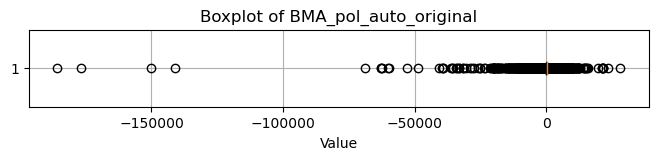

In [37]:
print("Boxplot of KPI in dataset X_train:\n")
plot_boxplot(X_train, KPI_copy)

In [38]:
# Make a copy of X_train and X_test before removing KPI_copy
X_train_with_KPI = X_train.copy()
X_test_with_KPI = X_test.copy()
# Remove KPI_copy from X_train and X_test before using any classification model
column_names = X.columns.tolist()
X_train = X_train.drop(columns=[KPI_copy])
X_test = X_test.drop(columns=[KPI_copy])
if KPI_copy in X_train:
    print("Variable", KPI_copy, "is still available in X_train.")
else: print("Variable", KPI_copy, "is NOT in X_train anymore.")    
if KPI_copy in X_train_with_KPI.columns:
    print("\nVariable", KPI_copy, "is still available in X_train_with_KPI.")
else: print("\nVariable", KPI_copy, "is NOT in X_train_with_KPI anymore.")    

Variable BMA_pol_auto_original is NOT in X_train anymore.

Variable BMA_pol_auto_original is still available in X_train_with_KPI.


In [39]:
# Scale data in X if requested
if use_scaling:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    print("Data in X has been scaled.")
else:
    print("Data in X has NOT been scaled.")

Data in X has been scaled.


## 6. Generate a Pool of Generic Classification Models

In [40]:
# Define a pool of non-parametrized classification models
models = [LogisticRegression(), 
          DecisionTreeClassifier(),
          XGBClassifier(), 
          LGBMClassifier(verbosity=-1),
          GaussianNB()]

# Other models can be added, but usually do not provide better results and consume a lot of computational time.
if fast_execution == False: models += [ExtraTreesClassifier(), 
                                       GradientBoostingClassifier(), 
                                       RandomForestClassifier(),
                                       AdaBoostClassifier(),
                                       CatBoostClassifier(verbose=False), 
                                       MLPClassifier(max_iter=10000)]

print("The following classification models will be employed:")
models_names = [type(model).__name__ for model in models]
print(models_names)

The following classification models will be employed:
['LogisticRegression', 'DecisionTreeClassifier', 'XGBClassifier', 'LGBMClassifier', 'GaussianNB']


In [41]:
# Assess models in the pool using cross-validation
models_results = {}
X_train_df = pd.DataFrame(X_train)
pred_train_df = pd.DataFrame(index=X_train_df.index) 
print("Assessing models in the pool using TRAIN data and cross-validation...")
for model in models:
    model_name = model.__class__.__name__
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=score_name)
    mean_score_train = scores.mean()
    models_results[model_name] = {'score_train': mean_score_train}
    print(f"Model: {model_name}, {score_name}: {mean_score_train:,.3f}")
    model.fit(X_train, y_train)
    pred_train_df[model_name] = model.predict(X_train) 

print("\nAll models in the pool have been fitted using the train data.")

# Select the best model in the pool and generate predictions
best_model_name = max(models_results, key=lambda x: models_results[x]['score_train'])
best_model = next(model for model in models if model.__class__.__name__ == best_model_name)
best_model_score_train = models_results[best_model_name]['score_train']
print(f"\nBest model in pool is {best_model_name}, with train {score_name}: {best_model_score_train:.3f}")

Assessing models in the pool using TRAIN data and cross-validation...
Model: LogisticRegression, roc_auc: 0.658
Model: DecisionTreeClassifier, roc_auc: 0.573
Model: XGBClassifier, roc_auc: 0.691
Model: LGBMClassifier, roc_auc: 0.699
Model: GaussianNB, roc_auc: 0.636

All models in the pool have been fitted using the train data.

Best model in pool is LGBMClassifier, with train roc_auc: 0.699


In [42]:
# Add the true class to predictions train dataframe and display rows with true_class=1
pred_train_df['true_class'] = y_train.values
print("Column 'true_class' has been added to the TRAIN dataframe.")

Column 'true_class' has been added to the TRAIN dataframe.


## 7. Consider a Consensus Model

In [43]:
# Function to determine consensus among models to assign a 0 (select) or a 1 (exclude) to a customer
num_models = len(models)
def consensus(row, required_ones_to_exclude):
    return int(sum(row[:num_models]) >= required_ones_to_exclude)

print("A function to determine consensus among models has been defined.")

A function to determine consensus among models has been defined.


In [44]:
# Function to determine the score value
def get_score(y_real, y_pred):
    if score_name == 'roc_auc': score = roc_auc_score(y_real, y_pred)
    elif score_name == 'f1': score = f1_score(y_real, y_pred)
    elif score_name == 'recall': score = recall_score(y_real, y_pred)
    elif score_name == 'precision': score = precision_score(y_real, y_pred)
    else: score = accuracy_score(y_real, y_pred)
    return score

print("A function to determine the score value based on 'score_name' has been defined.")

A function to determine the score value based on 'score_name' has been defined.


In [45]:
# Investigate which is the consensus model that maximizes score by changing the minimum consensus required
print("Investigating the ideal number of predicted 1s required to assign a 1 by consensus to a customer...")
best_k = 0
best_con_score_train = float('-inf')
num_columns = pred_train_df.shape[1]
for k in range(num_columns, 0, -1):
    pred_train_df['consensus'] = pred_train_df.apply(lambda row: consensus(row, k), axis=1)
    pred_consensus_train = pred_train_df['consensus'].to_numpy()
    score_train = get_score(y_train, pred_consensus_train)
    if score_train >= best_con_score_train:
        best_k = k
        best_con_score_train = score_train

# Update column with the consensus obtained for the best_k value
pred_train_df['consensus'] = pred_train_df.apply(lambda row: consensus(row, best_k), axis=1)
print(f"\nThe train consensus predictions have been updated using {best_k} required 1s to exclude.")
print(f"\nThe consensus model has a train {score_name} of {best_con_score_train:.3f}")

Investigating the ideal number of predicted 1s required to assign a 1 by consensus to a customer...

The train consensus predictions have been updated using 1 required 1s to exclude.

The consensus model has a train roc_auc of 0.914


In [46]:
print("\nDataframe of model's predictions with true_class=1 for TRAIN dataset:\n")
pred_train_df[pred_train_df['true_class'] == 1].head()


Dataframe of model's predictions with true_class=1 for TRAIN dataset:



,LogisticRegression,DecisionTreeClassifier,XGBClassifier,LGBMClassifier,GaussianNB,true_class,consensus
9,0,1,0,0,0,1,1
18,0,1,0,0,0,1,1
23,0,1,0,0,0,1,1
30,0,1,0,0,0,1,1
34,0,1,0,0,0,1,1


In [47]:
print("\nDataframe of model's predictions with true_class=0 for TRAIN dataset:\n")
pred_train_df[pred_train_df['true_class'] == 0].head()


Dataframe of model's predictions with true_class=0 for TRAIN dataset:



,LogisticRegression,DecisionTreeClassifier,XGBClassifier,LGBMClassifier,GaussianNB,true_class,consensus
0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,1
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0


In [48]:
# Use the consensus model to predict y_test values
X_test_df = pd.DataFrame(X_test)
pred_test_df = pd.DataFrame(index=X_test_df.index)
for model in models:
    model_name = model.__class__.__name__
    pred_test_df[model_name] = model.predict(X_test) 
print(f"Predictions on TEST dataset have been computed using all models in the pool and added to dataframe.")

Predictions on TEST dataset have been computed using all models in the pool and added to dataframe.


In [49]:
# Generate predictions on the TEST set using the best model in the pool
best_model_pred_test = best_model.predict(X_test)
print(f"Predictions on TEST dataset have been computed using {best_model_name}.")

Predictions on TEST dataset have been computed using LGBMClassifier.


In [50]:
# Add true_class values to TEST dataframe for visual inspection (that will not change the model)
pred_test_df['true_class'] = y_test.values
print("Column 'true_class' has been added to the TEST dataframe.")

Column 'true_class' has been added to the TEST dataframe.


In [51]:
# If consensus model has to be considered, check if it improves the best-pool one
pred_test_df['consensus'] = pred_test_df.apply(lambda row: consensus(row, best_k), axis=1)
if consider_consensus and best_con_score_train > best_model_score_train:
    best_model_pred_test = pred_test_df['consensus'].to_numpy()
    print("The consensus model will be used instead of the best-pool model.")
else: print("The best-pool model will be used (consensus not considered or best-pool's score is better).")

The consensus model will be used instead of the best-pool model.


In [52]:
print("\nDataframe of model's predictions with true_class=1 for TEST dataset:\n")
pred_test_df[pred_test_df['true_class'] == 1].head()


Dataframe of model's predictions with true_class=1 for TEST dataset:



,LogisticRegression,DecisionTreeClassifier,XGBClassifier,LGBMClassifier,GaussianNB,true_class,consensus
3,0,1,0,0,1,1,1
17,0,0,0,0,0,1,0
20,0,1,1,1,0,1,1
26,1,0,0,0,1,1,1
27,0,0,0,0,0,1,0


In [53]:
print("\nDataframe of model's predictions with true_class=0 for TEST dataset:\n")
pred_test_df[pred_test_df['true_class'] == 0].head()


Dataframe of model's predictions with true_class=0 for TEST dataset:



,LogisticRegression,DecisionTreeClassifier,XGBClassifier,LGBMClassifier,GaussianNB,true_class,consensus
0,0,0,0,1,0,0,1
1,0,0,1,0,0,0,1
2,0,1,1,1,0,0,1
4,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0


## 8. Using the Best Model to Estimate Benefits in X_test

In [54]:
# Define a function to compute benefits in a given dataset after selecting customers
def calc_benefit(predictions, X, details=True):
    X['class_predicted'] = predictions
    n_customers = len(predictions)
    if details:
        print(f"\nTotal customers in dataset: {n_customers:,.0f} customers")    
    # Filter dataset to select only selected customers (class 0)
    selected = X[X['class_predicted'] == 0]
    excluded = X[X['class_predicted'] == 1]
    others = X[~X.index.isin(selected.index) & ~X.index.isin(excluded.index)]
    n_selected = len(selected)
    n_excluded = len(excluded)
    n_others = len(others)
    if details:
        print(f"Total selected customers: {n_selected:,.0f} ({n_selected/n_customers*100:,.0f}%)")
        print(f"Total excluded customers: {n_excluded:,.0f} ({n_excluded/n_customers*100:,.0f}%)")
        print(f"Total other customers: {n_others:,.0f} ({n_others/n_customers*100:,.0f}%)")
        print(f"\nDescriptive statistics for selected (accepted) customers:")
        print(selected[KPI_copy].describe())
    max_benefit = X[X[KPI_copy] > 0][KPI_copy].sum()
    r_benefit = X[KPI_copy].sum() # real (actual) benefit without applying models
    p_r_benefit = int(round(100 * r_benefit / max_benefit, 0)) # percentage real benefit
    avg_r_benefit = r_benefit/n_customers # average real benefit per customer in dataset
    m_benefit = selected[KPI_copy].sum()
    p_m_benefit = int(round(100 * m_benefit / max_benefit, 0))
    avg_m_benefit = m_benefit/n_customers # average model benefit per customer in dataset
    if details:
        print(f"\nMaximum possible benefit in dataset: {max_benefit:,.0f} euros")
        print(f"Real benefit before model: {r_benefit:,.0f} euros ({p_r_benefit}% of max)")
        print(f"Avg. benefit before model: {avg_r_benefit:,.2f} euros per cust. in dataset")
        print(f"Est. benefit after model: {m_benefit:,.0f} euros ({p_m_benefit}% of max)")
        print(f"Avg. benefit after model: {avg_m_benefit:,.2f} euros per customer in dataset")
        print(f"\nDescriptive statistics for excluded customers:")
        print(excluded[KPI_copy].describe())
        print("\nBoxplots of KPI for selected and excluded customers:")
        plt.figure(figsize=(8, 2))
        plt.boxplot([selected[KPI_copy], excluded[KPI_copy]], vert=False, labels=['Selected 0', 'Excluded 1'])
        plt.show()
        print(f"\nSelected customers with positive KPI: {(selected[KPI_copy] > 0).sum():,.0f}")
        print(f"Selected customers with negative (or zero) KPI: {(selected[KPI_copy] <= 0).sum():,.0f}")
        print(f"Excluded customers with positive KPI: {(excluded[KPI_copy] > 0).sum():,.0f}")
        print(f"Excluded customers with negative (or zero) KPI: {(excluded[KPI_copy] <= 0).sum():,.0f}")
    return m_benefit

print("A function to compute benefits associated with the use of a model has been defined.")

A function to compute benefits associated with the use of a model has been defined.



Total customers in dataset: 15,464 customers
Total selected customers: 9,997 (65%)
Total excluded customers: 5,467 (35%)
Total other customers: 0 (0%)

Descriptive statistics for selected (accepted) customers:
count     9997.000000
mean       176.279017
std       1788.462515
min     -86528.878163
25%        108.323970
50%        189.739567
75%        286.488300
max      24107.363571
Name: BMA_pol_auto_original, dtype: float64

Maximum possible benefit in dataset: 4,313,963 euros
Real benefit before model: 583,570 euros (14% of max)
Avg. benefit before model: 37.74 euros per cust. in dataset
Est. benefit after model: 1,762,261 euros (41% of max)
Avg. benefit after model: 113.96 euros per customer in dataset

Descriptive statistics for excluded customers:
count      5467.000000
mean       -215.601105
std        3680.077748
min     -164739.693697
25%         -78.344703
50%         162.228846
75%         251.445167
max       13916.537500
Name: BMA_pol_auto_original, dtype: float64

Boxplo

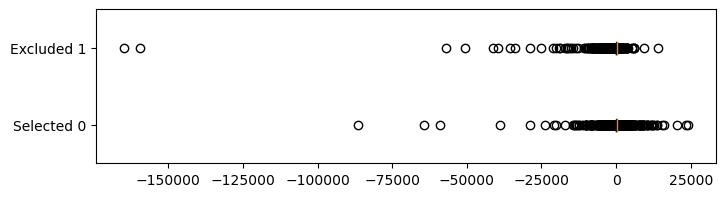


Selected customers with positive KPI: 8,646
Selected customers with negative (or zero) KPI: 1,351
Excluded customers with positive KPI: 3,857
Excluded customers with negative (or zero) KPI: 1,610


In [55]:
# Make sure X_test is a dataframe and compute associated benefits of using best_model
X_test_with_KPI = pd.DataFrame(X_test_with_KPI)
benefit = calc_benefit(best_model_pred_test, X_test_with_KPI)

## 9. Classification Reports


Careful!: this confusion matrix uses a threshold of 0.00


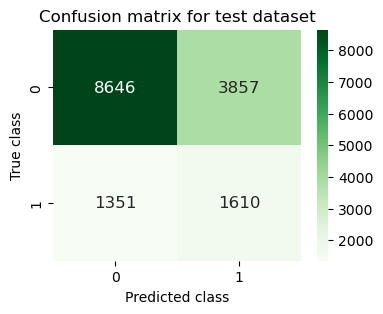

In [56]:
# Generate the confusion matrix
def plot_cf(cf, color):
    print(f"\nCareful!: this confusion matrix uses a threshold of {threshold:,.2f}")
    plt.figure(figsize=(4, 3))
    sns.heatmap(cf, annot=True, fmt='d', cmap=color, annot_kws={"fontsize": 12})
    plt.title('Confusion matrix for test dataset')
    plt.xlabel('Predicted class')
    plt.ylabel('True class')
    plt.show();

plot_cf(confusion_matrix(y_test, best_model_pred_test), 'Greens')

In [57]:
print("Classification report for test dataset:")
print(classification_report(y_test, best_model_pred_test))

Classification report for test dataset:
              precision    recall  f1-score   support

           0       0.86      0.69      0.77     12503
           1       0.29      0.54      0.38      2961

    accuracy                           0.66     15464
   macro avg       0.58      0.62      0.58     15464
weighted avg       0.76      0.66      0.69     15464



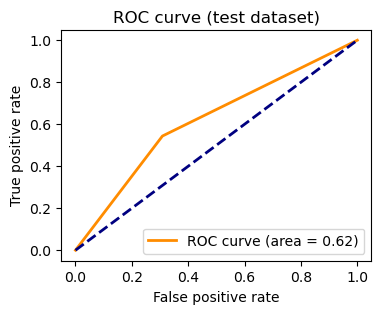

In [58]:
# Compute the ROC curve and the area under the ROC curve
def plot_roc(fpr, tpr, roc_auc):
    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (test dataset)')
    plt.legend(loc="lower right")
    plt.show()

fpr, tpr, thresholds = roc_curve(y_test, best_model_pred_test)
roc_auc = roc_auc_score(y_test, best_model_pred_test)
plot_roc(fpr, tpr, roc_auc)